In [1]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            
sns.set()

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [6]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) 

116805.0

У скользящей средней есть  применение - сглаживание исходного ряда для выявления трендов. Чем больше зададим ширину интервала - тем более сглаженным окажется тренд.

In [7]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

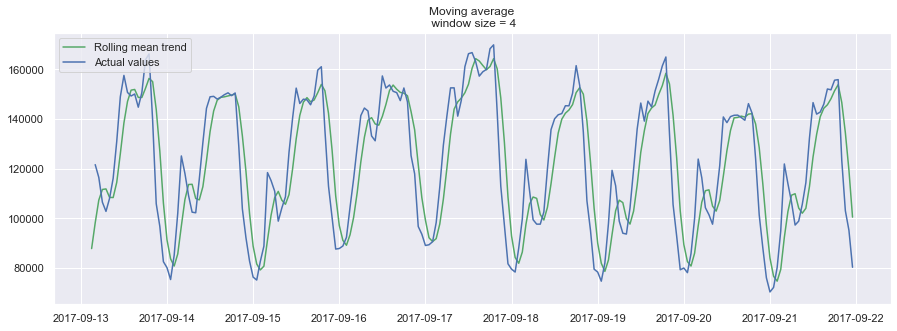

In [8]:
plotMovingAverage(ads, 4)  #Сглаживание по последним 4 часам

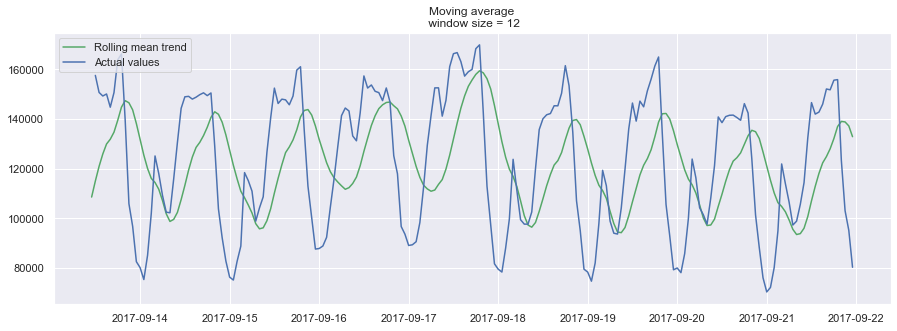

In [9]:
plotMovingAverage(ads, 12)  #По 12 часам (полдня)

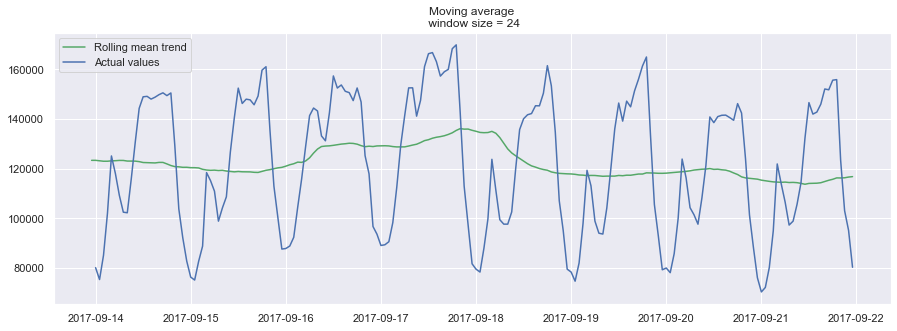

In [10]:
plotMovingAverage(ads, 24)  # дневной тренд

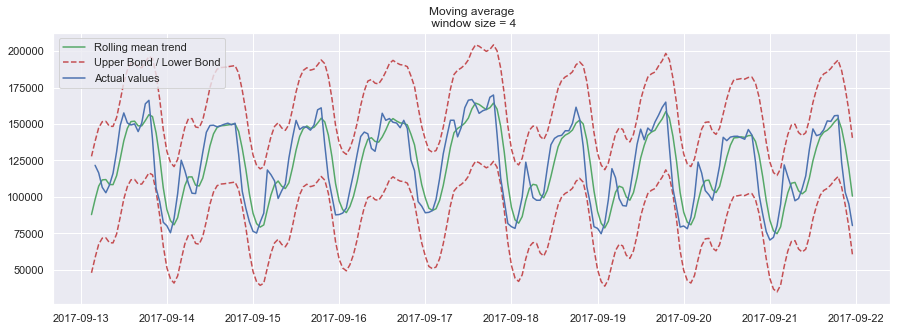

In [11]:
plotMovingAverage(ads, 4, plot_intervals=True) # доверительные интервалы

## Двойное экспоненциальное сглаживание

Cтроим прогноз сразу на две точки вперед.

In [21]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

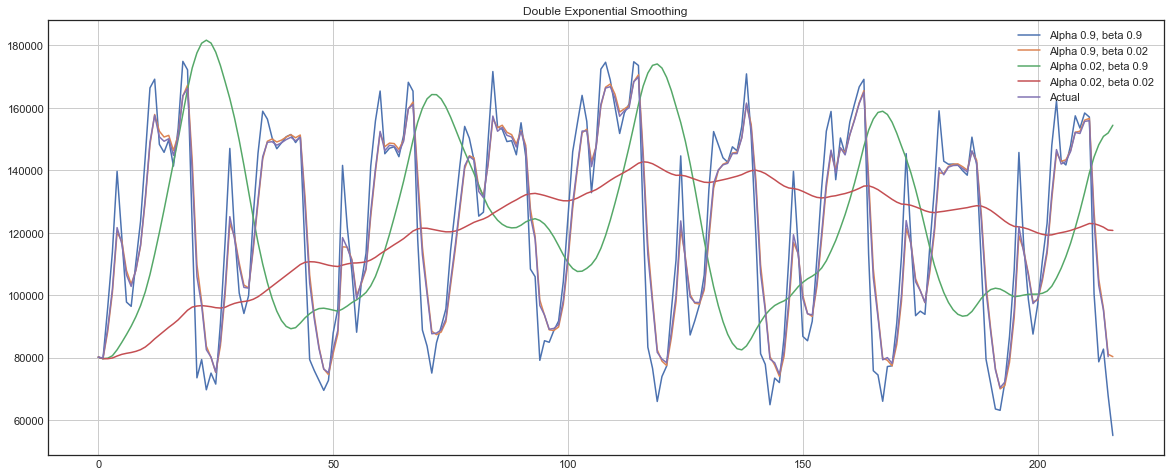

In [22]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

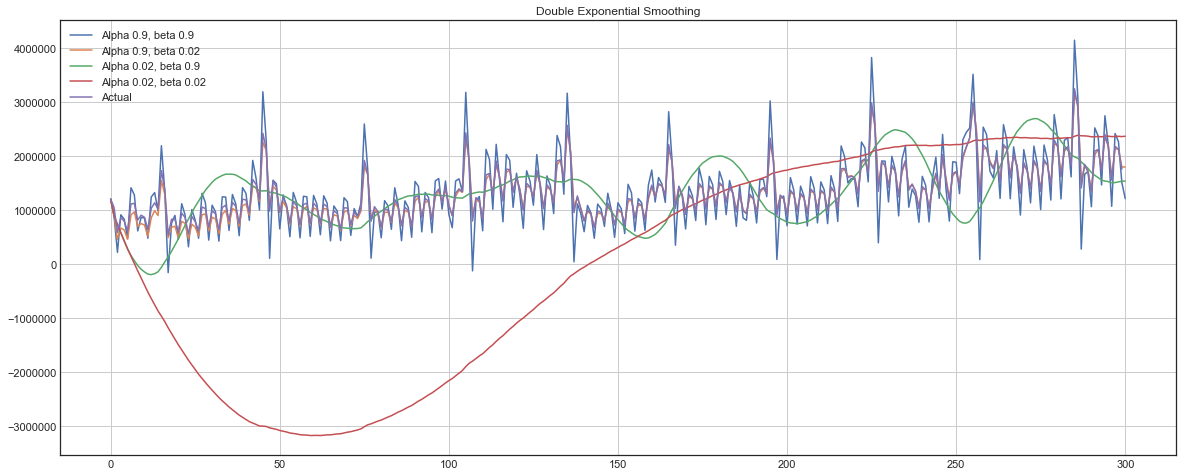

In [23]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Кросс-валидация 

In [25]:
from sklearn.model_selection import TimeSeriesSplit # параметры для модели Хольта-Винтерса

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [26]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11427352650843281 0.002411173452740667 0.08660326362102416
CPU times: user 2.62 s, sys: 10.7 ms, total: 2.63 s
Wall time: 2.63 s


In [27]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

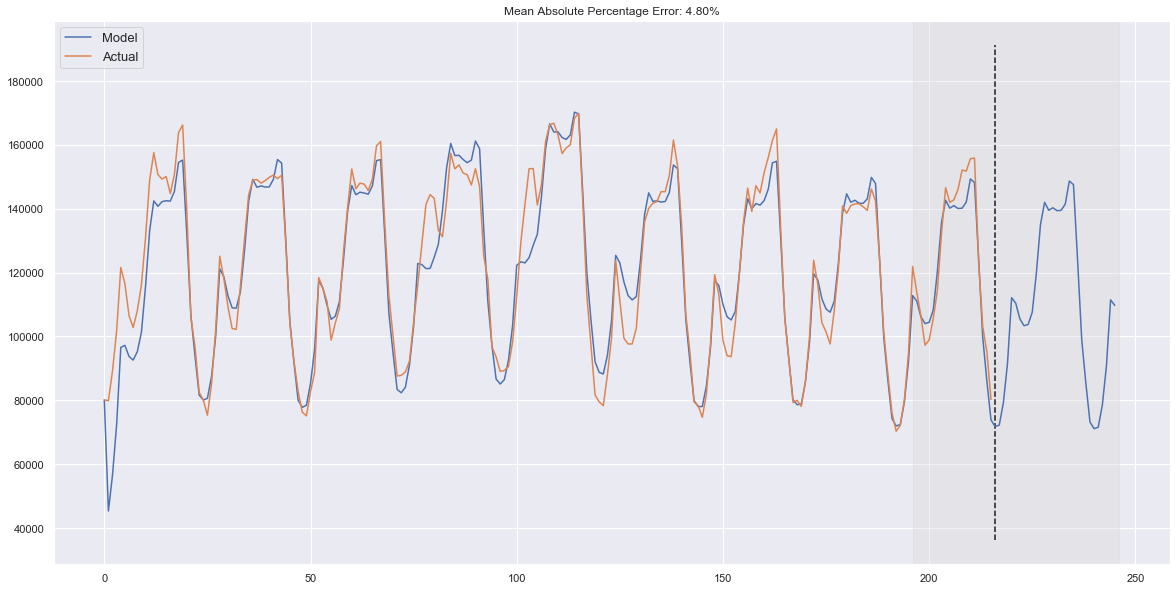

In [28]:
plotHoltWinters(ads.Ads)

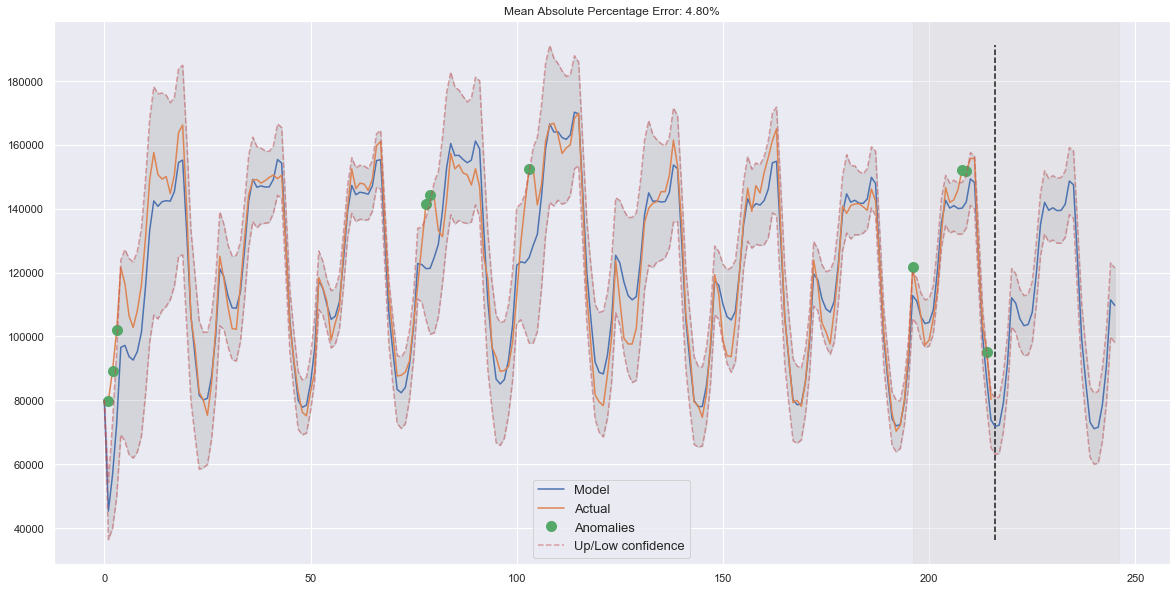

In [29]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

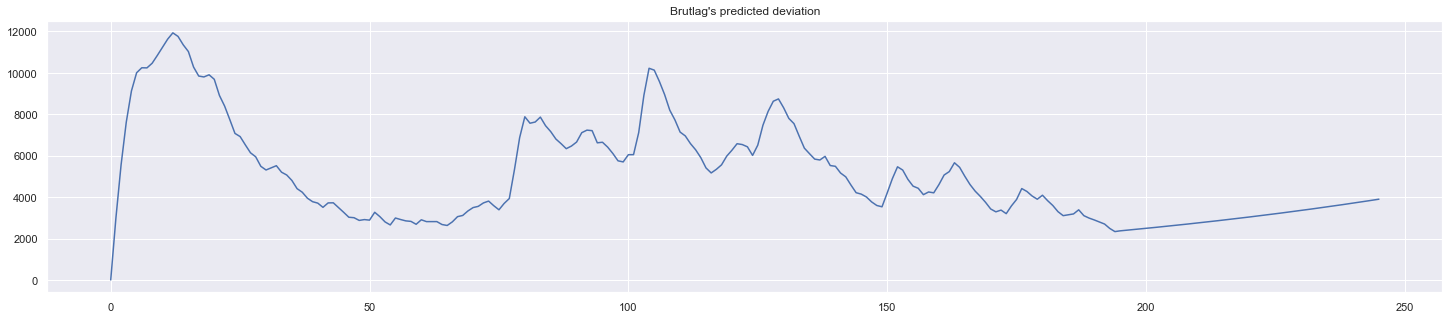

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Прогоним тот же самый алгоритм для второго временного ряда

In [35]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 2.49 s, sys: 11.7 ms, total: 2.51 s
Wall time: 2.5 s


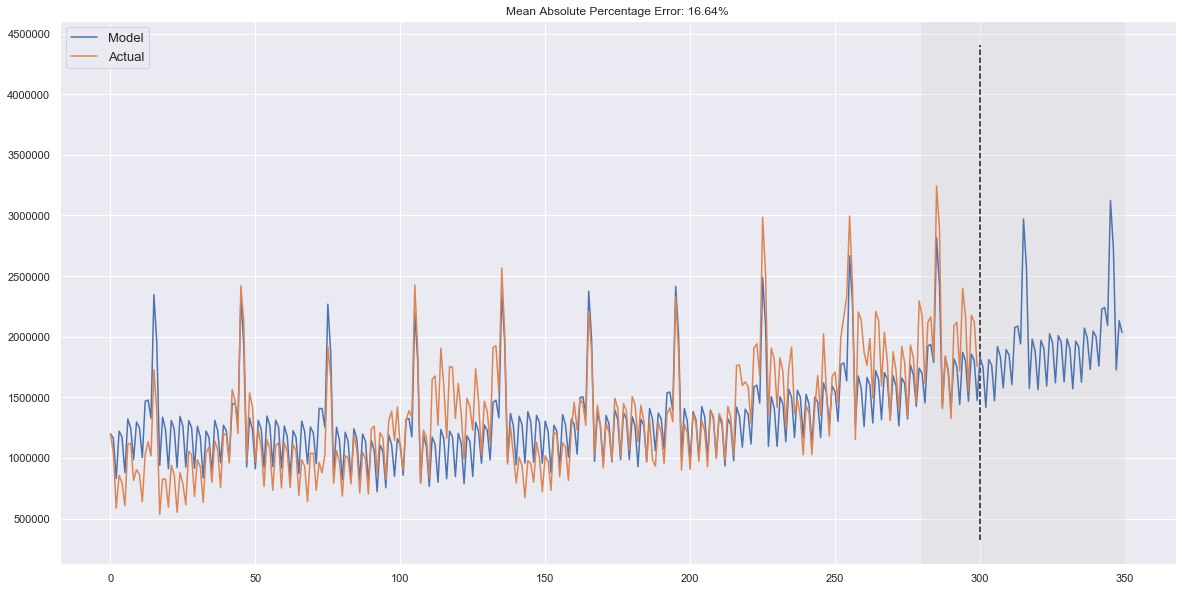

In [36]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

 модель уловила и восходящий тренд, и сезонные пики

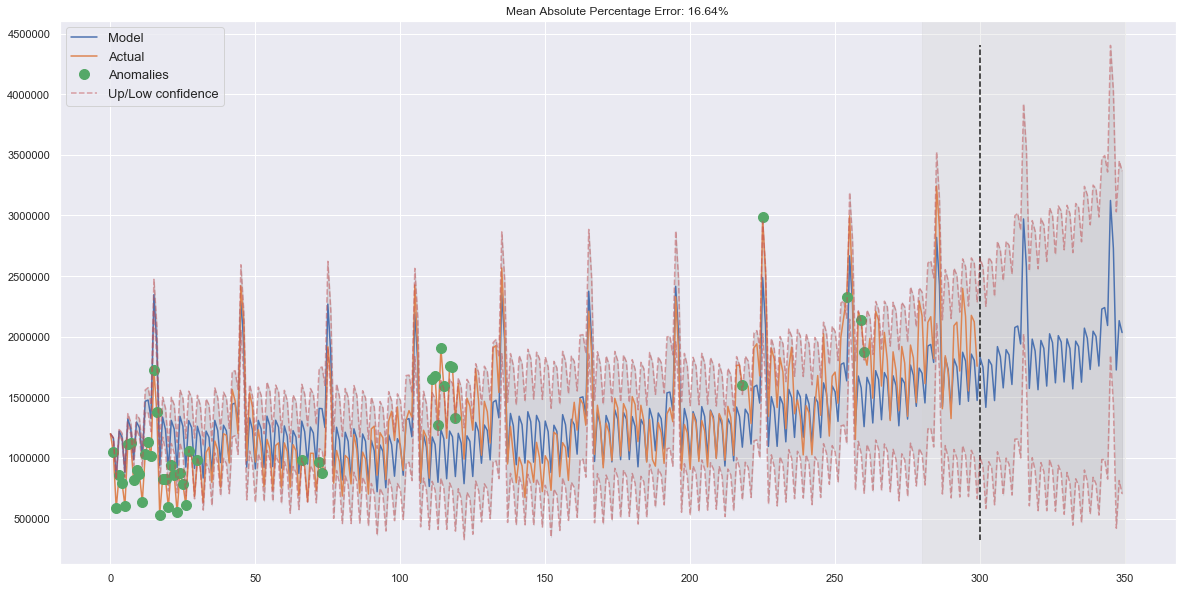

In [37]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

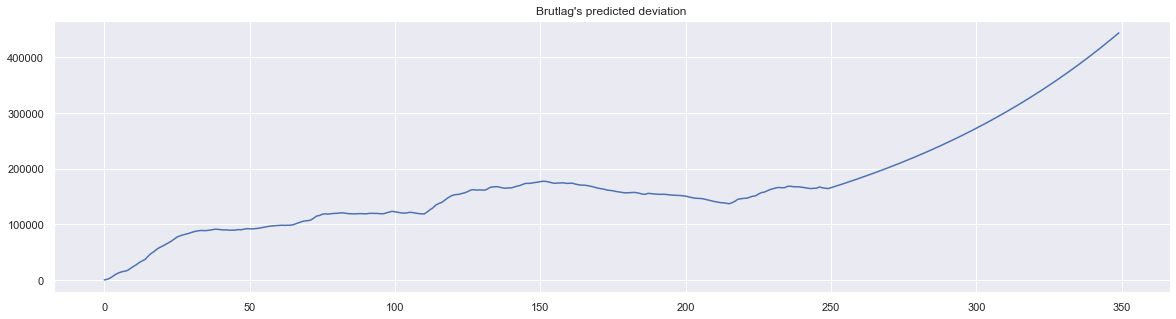

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");